In [1]:
# Load libraries
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from sklearn.decomposition import PCA


#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers

#network diagrams
import networkx as nx

In [2]:
df = pd.DataFrame(pd.read_csv("eikon.csv"))
df

,Date,005930.KS,601988.SS,6758.T,BABA.K,BASFn.DE,BHPB.L,KO,MDT,PG,RDSa.AS,RTX,SAPG.DE,SASY.PA,SCHN.PA,VOD.L,VOWG_p.DE,WMT
0,1990-01-02T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,4.87500,2.046875,8.745084,8.423295,4.091839,NaN,9.831230,17.836910,26.772856,NaN,5.89075
1,1990-01-03T00:00:00Z,463.404554,NaN,NaN,NaN,NaN,NaN,4.80475,2.054688,8.729579,8.536740,4.045760,NaN,9.735950,17.874621,27.106682,NaN,5.89075
2,1990-01-04T00:00:00Z,468.576480,NaN,NaN,NaN,NaN,NaN,4.78125,2.105500,8.559019,8.360900,4.036544,NaN,9.891863,18.006606,26.706091,NaN,5.85950
3,1990-01-05T00:00:00Z,458.232628,NaN,NaN,NaN,NaN,NaN,4.74225,2.148438,8.403964,8.224766,4.036544,NaN,9.839892,18.044316,26.372265,NaN,5.79700
4,1990-01-06T00:00:00Z,460.301399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8554,2021-05-05T00:00:00Z,NaN,NaN,NaN,226.78,69.36,2306.0,54.00000,127.000000,133.460000,16.494000,84.130000,115.84,84.590000,134.540000,140.540000,218.00,140.60000
8555,2021-05-06T00:00:00Z,82300.000000,3.26,10715.0,226.42,70.22,2314.0,54.54000,127.300000,135.140000,16.510000,84.680000,116.42,84.300000,134.180000,142.020000,212.40,141.05000
8556,2021-05-07T00:00:00Z,81900.000000,3.28,10470.0,225.31,70.38,2337.5,54.51000,126.700000,135.150000,16.612000,85.710000,117.36,85.440000,134.960000,141.820000,210.75,140.20000
8557,2021-05-10T00:00:00Z,83200.000000,3.26,10780.0,219.53,70.76,2375.5,54.91000,126.900000,137.670000,16.650000,85.040000,115.60,86.370000,130.920000,142.420000,211.90,140.82000


In [3]:
df["Date"] = pd.to_datetime(df["Date"])

In [4]:
df = df.set_index("Date")

In [5]:
df.columns = ["Samsung", "BankChina", "Sony", "Alibaba", "BASF", "BHPB", "CocaCola", "Medtronic", "PG", "Shell", "RTX", "SAP", "Sanofi", "Schneider", "Vodafone", "VW", "Walmart"] 

#### defining log returns

importance for difference between high price and low price stocks

In [6]:
logreturns = df.pct_change()
logreturns.dropna(inplace=True)
logreturns

,Samsung,BankChina,Sony,Alibaba,BASF,BHPB,CocaCola,Medtronic,PG,Shell,RTX,SAP,Sanofi,Schneider,Vodafone,VW,Walmart
Date,,,,,,,,,,,,,,,,,
2014-09-22 00:00:00+00:00,-0.018182,-0.018382,-0.012754,-0.042603,-0.004667,-0.035127,0.004043,-0.003624,0.004025,-0.000491,-0.018257,0.006073,0.001239,-0.011302,-0.015392,-0.012762,-0.006897
2014-09-23 00:00:00+00:00,-0.022727,0.003745,0.000000,-0.030259,-0.017192,0.006357,-0.007816,-0.028797,-0.004363,-0.009652,-0.009862,-0.010003,-0.016428,-0.019965,-0.014144,-0.018673,-0.009304
2014-09-24 00:00:00+00:00,-0.009475,0.007463,-0.011864,0.039004,0.002650,0.032156,0.009071,-0.004838,0.009474,0.002478,0.006166,0.002962,0.017275,0.010514,0.028190,-0.003806,0.019577
2014-09-25 00:00:00+00:00,0.005217,0.000000,0.014408,-0.018218,-0.036611,-0.028651,-0.011592,-0.015995,-0.010676,-0.011534,-0.014896,-0.013896,-0.020580,-0.017721,0.002448,-0.021158,-0.012455
2014-09-26 00:00:00+00:00,0.025087,-0.003704,-0.001052,0.017319,0.003704,-0.008018,0.010053,0.009402,0.002965,0.001500,0.007178,0.009512,0.015157,0.004303,0.000977,-0.001501,0.004861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-05 00:00:00+00:00,0.000000,0.000000,0.000000,-0.004914,0.037857,0.049852,-0.002586,-0.011673,-0.008027,0.022820,0.002264,0.027497,-0.026022,0.021564,0.019736,0.035876,-0.000853
2021-05-06 00:00:00+00:00,-0.003632,0.003077,-0.016972,-0.001587,0.012399,0.003469,0.010000,0.002362,0.012588,0.000970,0.006538,0.005007,-0.003428,-0.002676,0.010531,-0.025688,0.003201
2021-05-07 00:00:00+00:00,-0.004860,0.006135,-0.022865,-0.004902,0.002279,0.010156,-0.000550,-0.004713,0.000074,0.006178,0.012163,0.008074,0.013523,0.005813,-0.001408,-0.007768,-0.006026


https://www.linkedin.com/pulse/efficient-frontier-portfolio-optimisation-inpython-ricky-kim/

In [7]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [8]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(17)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [9]:
returns = logreturns
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [10]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    plt.figure(figsize=(20, 14))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='.',color='r',s=250, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='.',color='g',s=250, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns').set_rotation(90)
    plt.legend(labelspacing=0.8)

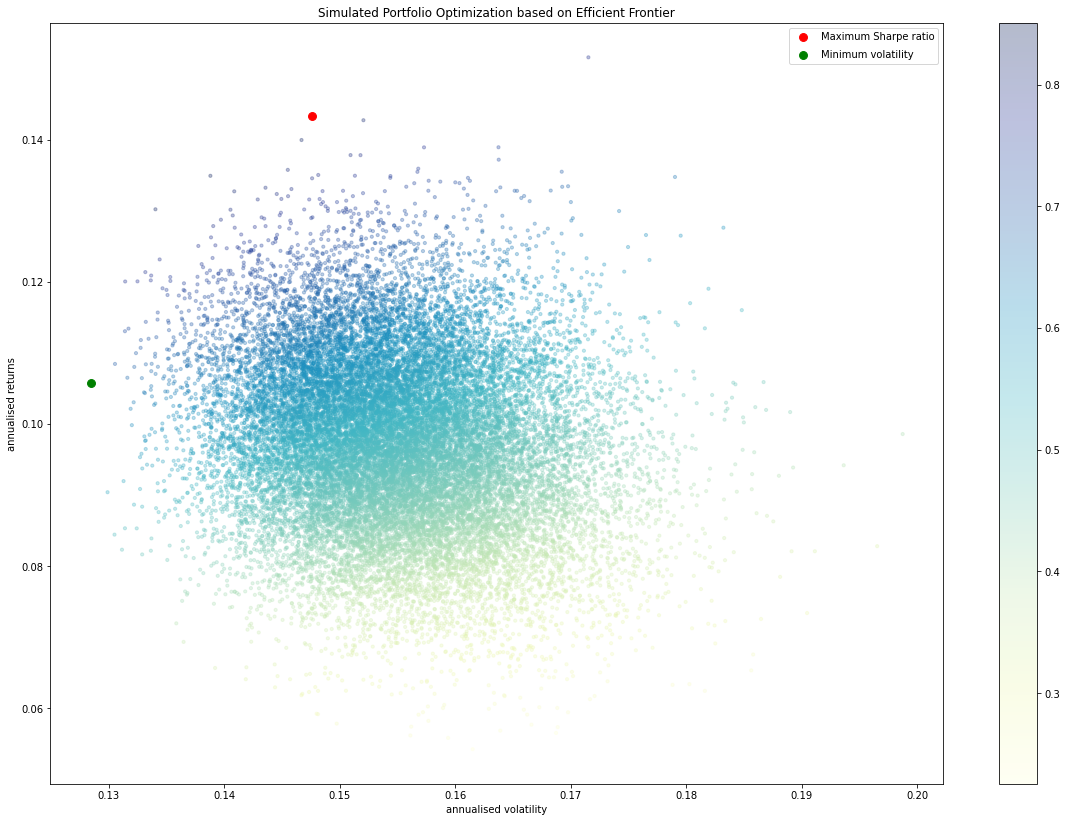

In [11]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [12]:
import scipy.optimize as sco

In [13]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
def portfolio_volatility(weights, mean_returns, cov_matrix):return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [15]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [20]:
import matplotlib.pyplot as plt

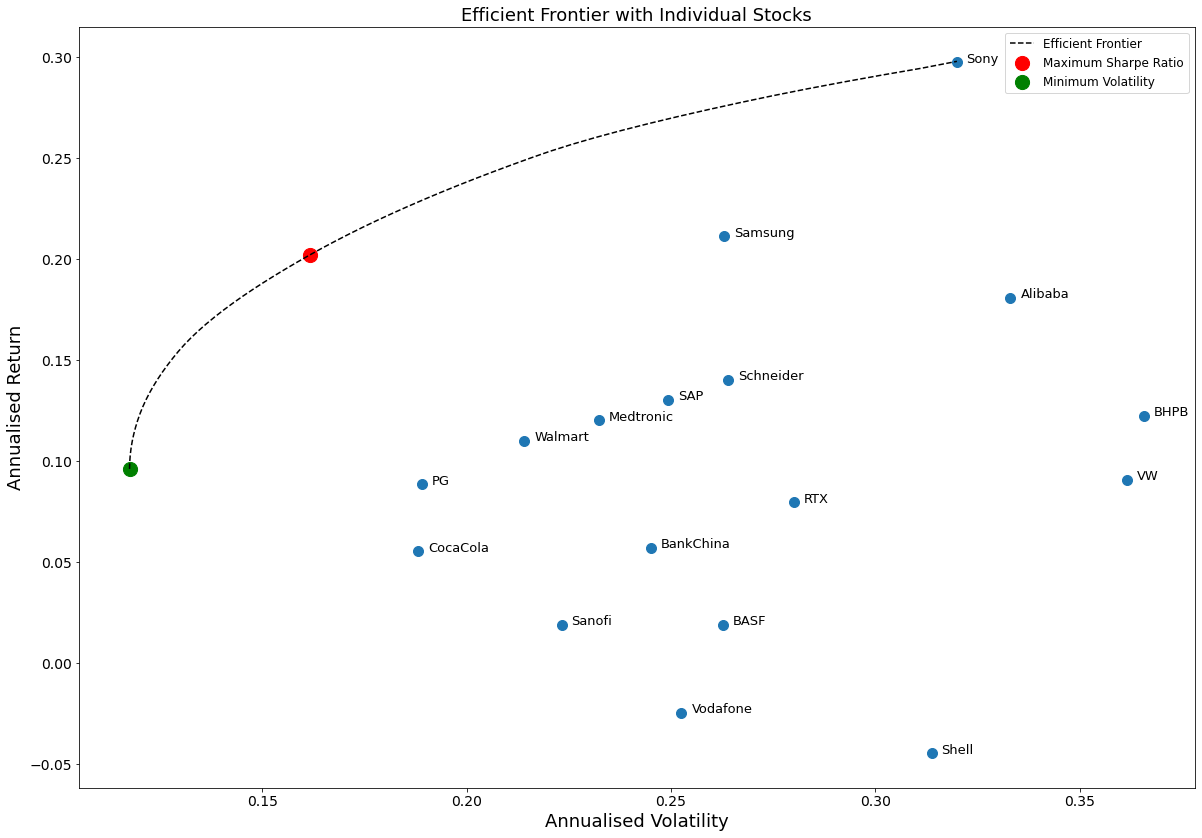

In [44]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=returns.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.scatter(an_vol,an_rt,marker='o',s=100)

    for i, txt in enumerate(returns.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points', fontsize=13)
    ax.scatter(sdp,rp,marker='o',color='r',s=200, label='Maximum Sharpe Ratio')
    ax.scatter(sdp_min,rp_min,marker='o',color='g',s=200, label='Minimum Volatility')

    target = np.linspace(rp_min, 0.298, 60)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='--', color='black', label='Efficient Frontier')
    ax.set_title('Efficient Frontier with Individual Stocks', fontsize=18)
    ax.set_xlabel('Annualised Volatility',fontsize=18)
    ax.set_ylabel('Annualised Return',fontsize=18).set_rotation=90
    ax.legend(labelspacing=0.5, fontsize=12)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)